## Import Datasets

In [1]:
import torch
import torchvision
#from torchvision.datasets import CIFAR10
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader
from model import Alexnet, MyModule
from utils import matplotlib_imshow, plot_classes_preds, 
from labml import tracker, experiment

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.tensorboard import SummaryWriter
# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/mnist')
#from cv2_plt_imshow import matplotlib_imshow

## Transform data

In [2]:
pipeline = transforms.Compose([transforms.ToTensor()])
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Load Data and break them into batches

In [3]:
data_train = MNIST('mnist', download = True, train = True, transform= pipeline)
data_test = MNIST('mnist', download = True, train = False, transform= pipeline)
trainloader = DataLoader(data_train, batch_size=16, shuffle=True)
testloader = DataLoader(data_test, batch_size=16, shuffle=False)
train_iter = iter(trainloader)
images, labels = train_iter.next()

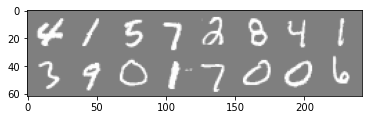

In [4]:
# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid)

# write to tensorboard
writer.add_image('mnist_images', img_grid)

## Add projector to tensorboard

In [5]:
# helper function
def select_n_random(data, labels, n=100):
    '''
    Selects n random datapoints and their corresponding labels from a dataset
    '''
    assert len(data) == len(labels)

    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]

In [6]:
import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

In [7]:
# constant for classes
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')
# select random images and their target indices
imagesx, labels = select_n_random(data_train.data, data_train.targets)

# get the class labels for each image
class_labels = [classes[lab] for lab in labels]

# log embeddings
features = imagesx.view(-1, 28 * 28)
writer.add_embedding(features,
                    metadata=labels,
                    label_img=imagesx.unsqueeze(1))
writer.close()

In [8]:
#!tensorboard --logdir=runs

## Load model

In [9]:
#net = Alexnet()
net = MyModule().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
criterion = nn.CrossEntropyLoss()

In [10]:
writer.add_graph(net, images)
writer.close()

## Train Loop

In [13]:
# loop over the dataset multiple times
#with experiment.record(name='sample', exp_conf=conf):
def train(net, trainloader, optimizer, epoch=5):
    net.train()
    for epoch in range(epoch):
        running_loss = 0.0
        correct = 0
        total = 0
        for batch_idx, data in enumerate(trainloader, 0):   
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

                    # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            if batch_idx % 1000 == 999:    # every 1000 mini-batches...
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(data), len(trainloader.dataset),
                100. * batch_idx / len(trainloader), loss.item()))
                # ...log the running loss
                writer.add_scalar('training loss', running_loss / 1000, epoch * len(trainloader) + batch_idx)
                # ...log a Matplotlib Figure showing the model's predictions on a
                # random mini-batch
                writer.add_figure('predictions vs. actuals', plot_classes_preds(net, inputs, labels, classes),          global_step=epoch* len(trainloader) + batch_idx)
                print('Accuracy of the network: %d %%' % (100 * correct / total))
                writer.add_scalar('training accuracy', (100 * correct / total))
                running_loss = 0.0
        print('Loss: {}'.format(running_loss))
    print('Finished Training')

In [14]:
train(net, trainloader, optimizer, epoch=10)

Train Epoch: 0 [1998/60000 (27%)]	Loss: 0.584805
Train Epoch: 0 [3998/60000 (53%)]	Loss: 0.010692
Train Epoch: 0 [5998/60000 (80%)]	Loss: 0.139291
Loss: 103.05937508604256
Train Epoch: 1 [1998/60000 (27%)]	Loss: 0.004618
Train Epoch: 1 [3998/60000 (53%)]	Loss: 0.000014
Train Epoch: 1 [5998/60000 (80%)]	Loss: 0.239570
Loss: 101.82252689422057
Train Epoch: 2 [1998/60000 (27%)]	Loss: 0.005013
Train Epoch: 2 [3998/60000 (53%)]	Loss: 0.069302
Train Epoch: 2 [5998/60000 (80%)]	Loss: 0.001116
Loss: 77.51070348472604
Train Epoch: 3 [1998/60000 (27%)]	Loss: 0.005728
Train Epoch: 3 [3998/60000 (53%)]	Loss: 0.020411
Train Epoch: 3 [5998/60000 (80%)]	Loss: 0.158194
Loss: 76.27738984924235
Train Epoch: 4 [1998/60000 (27%)]	Loss: 0.018512
Train Epoch: 4 [3998/60000 (53%)]	Loss: 0.037790
Train Epoch: 4 [5998/60000 (80%)]	Loss: 0.011429
Loss: 83.46801477650683
Train Epoch: 5 [1998/60000 (27%)]	Loss: 0.018448
Train Epoch: 5 [3998/60000 (53%)]	Loss: 0.003289
Train Epoch: 5 [5998/60000 (80%)]	Loss: 0.236

## Assessing trained models with TensorBoard

In [17]:
# 1. gets the probability predictions in a test_size x num_classes Tensor
# 2. gets the preds in a test_size Tensor
# takes ~10 seconds to run
class_probs = []
class_label = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        output = net(images)
        class_probs_batch = [F.softmax(el, dim=0) for el in output]

        class_probs.append(class_probs_batch)
        class_label.append(labels)

test_probs = torch.cat([torch.stack(batch) for batch in class_probs])
test_label = torch.cat(class_label)

# helper function
def add_pr_curve_tensorboard(class_index, test_probs, test_label, global_step=0):
    '''
    Takes in a "class_index" from 0 to 9 and plots the corresponding
    precision-recall curve
    '''
    tensorboard_truth = test_label == class_index
    tensorboard_probs = test_probs[:, class_index]

    writer.add_pr_curve(classes[class_index],
                        tensorboard_truth,
                        tensorboard_probs,
                        global_step=global_step)
    writer.close()

# plot all the pr curves
for i in range(len(classes)):
    add_pr_curve_tensorboard(i, test_probs, test_label, classes)

## Save model

In [21]:
PATH = './runs/mnist.pth'
torch.save(net.state_dict(), PATH)

## Test the network on the test data

GroundTruth:  Sneaker Pullover Trouser T-shirt/top


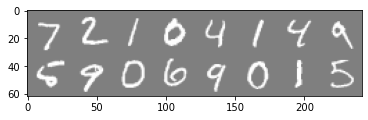

In [24]:
from matplotlib.pyplot import imshow
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
matplotlib_imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [26]:
infnet = MyModule()
infnet.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [27]:
outputs = net(images)

In [29]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:  Sneaker Pullover Trouser T-shirt/top


In [30]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 97 %


In [31]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class T-shirt/top is: 99.1 %
Accuracy for class Trouser is: 98.9 %
Accuracy for class Pullover is: 97.8 %
Accuracy for class Dress is: 97.4 %
Accuracy for class Coat  is: 96.2 %
Accuracy for class Sandal is: 94.6 %
Accuracy for class Shirt is: 98.0 %
Accuracy for class Sneaker is: 96.3 %
Accuracy for class Bag   is: 97.0 %
Accuracy for class Ankle Boot is: 94.3 %


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3fe7cd35-e1c3-486d-8a85-6e94f9a0da39' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>

## Reference

https://github.com/fepegar/torchio